In [143]:
import numpy as np
import scipy
from scipy.integrate import solve_ivp
import scipy.integrate as integrate
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


The critical temperature, TC:  139.274
Value of phi at TC:  199.302
Latent heat:  0.025608087090660224
vC/TC:  1.4310082201279886


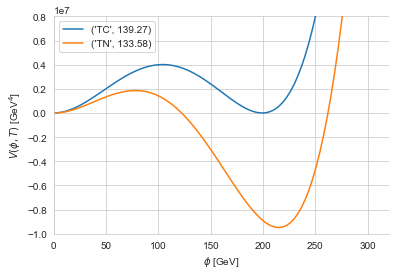

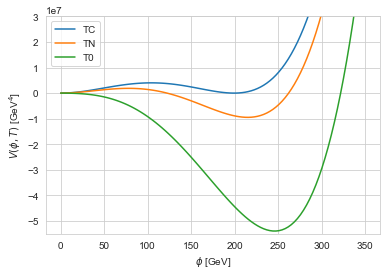

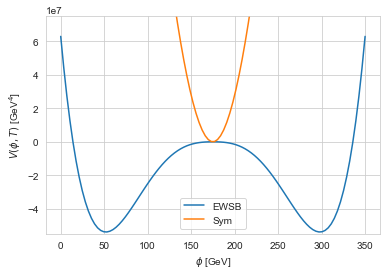

In [448]:
# T = 0 masses
mW0 = 80   #W boson mass
mZ0 = 91  #Z boson mass
mh0 = 125   #Higgs mass 
v0 = 246.0    #Higgs VEVss
mt0 = 173   #Top quark mass
lambdaH = mh0**2/(2*v0**2)  # lambda

mS2 = 450**2
lambdaHS = 3.2
muS = mS2 - lambdaHS*v0**2
muH = mh0/(np.sqrt(2))

# Coefficients in eq (213)
D = (2*mW0**2 + mZ0**2 + 2*mt0**2)/(8*v0**2) + lambdaH/8        # added T^2 term from Higgs
E = (2*mW0**3 + mZ0**3)/(4*np.pi*v0**3) + lambdaH/4             # added T term from Higgs
B = 3/(64*np.pi**2*v0**4)*(2*mW0**4 + mZ0**4 - 4*mt0**4)                
Tmin2 = (mh0**2 -8*B*v0**2)/(4*D)
CWextra = 2/(64*np.pi**2)*(mh0**2*3*lambdaH + lambdaHS*mS2)         # 2/(64*np.pi**2)*(lambdaHS*mS2) without Higgs # 2/(64*np.pi**2)*(mh0**2*3*lambdaH + lambdaHS*mS2)
#Tmin2 = mh0**2/(4*D)                        # if B = 0

def diffLambda(T, h):
    lambdaTemp = - 3*(2*mW0**4*(np.log(mW0**2/T**2) - (5.4076- 1.5))\
                    + mZ0**4*(np.log(mZ0**2/T**2) - (5.4076 -1.5)) - 4*mt0**4*(np.log(mt0**2/T**2) - (2.6351 -1.5)))/(16*np.pi**2*v0**4)\
                        - 9*lambdaH**2*(np.log(mh0**2/T**2) - (5.4076 -1.5))/(64*np.pi**2)          #log terms from higgs
    logTerm = 1 + (h**2 - v0**2)*lambdaHS/mS2
    
    lambdaCW = lambdaHS**2/(16*np.pi**2)*(np.log(logTerm) - 3/2)
    return lambdaH + lambdaTemp + lambdaCW

phi = np.linspace(0, 350, 100)

def derivativeDiffLambda(h):
    logTerm = 1 + (h**2 - v0**2)*lambdaHS/mS2
    derLog = 1/(logTerm)
    derH = 2*h*lambdaHS/mS2
    return lambdaHS**2/(16*np.pi**2)*derLog*derH

# Add term prop to T with contribution from Higgs (m^2/T^2)^(3/2)
def potential(phi, T):
    
    if isinstance(phi, float):
        return D*(T**2 - Tmin2)*phi**2 - E*T*np.abs(phi)**3 + diffLambda(T, phi)*phi**4/4 + CWextra*phi**2 #+ 2/(64*np.pi**2)*(muS*mS2)  # - muH*mh0**2)

    else:
        quarticTerm = []    
        for h in phi:
            quarticTerm.append(diffLambda(T, h)*h**4/4)

        quartic = np.array(quarticTerm)

        return D*(T**2 - Tmin2)*phi**2 - E*T*np.abs(phi)**3  + quartic + CWextra*phi**2 #+ 2/(64*np.pi**2)*(muS*mS2)     # - muH*mh0**2)

def dVdphi(phi, T):
    # Derivative of the potential w.r.t phi
    if isinstance(phi, float):
        der = 2*D*(T**2 - Tmin2)*phi - 3*E*T*phi**2 + (diffLambda(T, phi)*phi**3 + derivativeDiffLambda(phi)*phi**4/4) + 2*CWextra*phi

    else:
        qubicTerm = []
        quarticTerm = []    
        for h in phi:
            qubicTerm.append(diffLambda(T, h)*h**3)
            quarticTerm.append(derivativeDiffLambda(h)*h**4/4)

        qubic = np.array(qubicTerm)
        quartic = np.array(quarticTerm)

        der = 2*D*(T**2 - Tmin2)*phi - 3*E*T*phi**2 + qubic + quartic + 2*CWextra*phi
    #print("dVdphi: ", der)
    return der

def dVdT(phi, T):
    # Derivative of the potential w.r.t T
    return 2*D*T*phi**2 - E*phi**3

def equations(x):
    # The critical temperature is when we have a degenerate minimum, i.e dVdphi = 0 and V = V(phi_F) = 0.
    # Hence define a system of non-linear equations with V = 0 and dV/dphi = 0 
    phi, T = x
    V = potential(phi, T) #- 2/(64*np.pi**2)*(muS*mS2)       # - muH*mh0**2)
    dV = dVdphi(phi, T)
    return [V, dV]

# Use fsolve to find the roots of the system of equations
# Use the last point of the span of phi as an initial guess to find the right minimum, not phi_F = 0
phiAtMin, TC = fsolve(equations, [phi[50], mh0])
print('The critical temperature, TC: ', np.around(TC, 3))
print('Value of phi at TC: ', np.around(phiAtMin, 3))

#TN = 126.75
TN = 133.57651572527107

def findT0forVEV(t):
    dV = dVdphi(v0, t)
    return dV

T0, = fsolve(findT0forVEV, TN)

def latentHeat(TN, T0, v0):
    rhoR = 106.75*np.pi**2*TN**4/30
    VEW = potential(v0, T0)
    VF = 0
    dVEWdT = dVdT(v0, T0)
    dVFdT = 0
    alpha = (VF - VEW + TN*(dVEWdT - dVFdT))/rhoR
    return alpha

potentialTC = potential(phi, TC)
potentialTN = potential(phi, TN)
potentialT0 = potential(phi, T0)

alpha = latentHeat(TN, T0, v0)
print('Latent heat: ', alpha)

plt.figure()
plt.plot(phi, potentialTC, label=('TC', np.around(TC,2)))
plt.plot(phi, potentialTN, label=('TN', np.around(TN,2)))
plt.legend()
plt.xlabel('$\phi$ [GeV]')
plt.ylabel('$V(\phi, T)$ [GeV$^4$]')
plt.ylim([-1e7, 8e6])
plt.xlim([0,320])
sns.despine()

plt.figure()
plt.plot(phi, potentialTC, label='TC')
plt.plot(phi, potentialTN, label='TN')
plt.plot(phi, potentialT0, label='T0')
plt.legend()
plt.xlabel('$\phi$ [GeV]')
plt.ylabel('$V(\phi, T)$ [GeV$^4$]')
plt.ylim([-5.5e7, 3e7])

phi2 = np.linspace(-350, 350, 100)

potentialSym = potential(phi2, 2*TC)
potentialBroken = potential(phi2, T0)

plt.figure()
plt.plot(phi, potentialBroken, label='EWSB')
plt.plot(phi, potentialSym, label='Sym')
plt.legend()
plt.xlabel('$\phi$ [GeV]')
plt.ylabel('$V(\phi, T)$ [GeV$^4$]')
plt.ylim([-5.5e7, 7.5e7])

# der = dVdT(phi, 250)
# plt.figure()
# plt.plot(phi, der)
#plt.ylim([-2e5, 2e5])

#print(potentialTC)

print('vC/TC: ', phiAtMin/TC)

In [210]:
def equationsBounce(r, y, temp):
    """
    Function setting our equation system from the EOM of the bounce. 
    Turning equation of 2nd order ODE, to system of two 1st order ODEs.

        From: dphi^2/dr^2 + (alpha/r)*dphi/dr = dV/dphi

            introduce v = dphi/dr, s.t dv/dr = dphi^2/dr^2
            and then y = [phi, v], dy/dr = [dphi/dr, dv/dr]

        To: dy/dr = [dphi/dr, dv/dr] = [v, -(alpha/r)*dphi/dr + dV/dphi]                                              

    @param r: For T=0, r = sqrt(t^2 + x^2), for finite T r = r
           y: Array of phi and dphi/dr
           alpha: D-1 term, equals either 3 in 4D or 2 in 3D
    @return dydr: Array of dphi/dr and dphi^2/dr^2
    """
    # Pick out the values from y = [phi, v]
    phi = y[0]
    v = y[1]        # v = dphi/dr

    #print("Phi: ", phi, "Temperature: ", temp)    
    # Finite-T
    alpha = 2

    # Define the derivatives
    dphidr = v
    dvdr = - (alpha/r)*v + dVdphi(phi, temp)     # - (alpha/r)*v is the friction term, dVdphi(phi) the derivative of the potential (-)V(phi)
    #print("r: ", r, "dvdr", dvdr, "\n")
    
    # Set dy/dr = [dphi/dr, dv/dr]
    dydr = np.array([dphidr, dvdr])
    
    return dydr

In [146]:
def findAction(phiB, dPhiB, rad_span, temperature):
    potentialBounce = potential(phiB, temperature)
    integrand = rad_span**2*(0.5*dPhiB**2 + potentialBounce)
    integral = np.trapz(integrand, rad_span)
    S = integral*4*np.pi
    action = S/temperature
    return action

In [443]:
def shootingActionAdjusted(r0, rmin, rmax, dr, phiTrueVacuum, phiFalseVacuum, undershoot, tol, actionTol, temp):
    
    # Set tolerance for which we accept our numerical solution
    # and a maximum of iteration to abrupt the while loop 
    #tol = 1e-3
    max_iters = 100
    radius = 0
    actionB = 0

    # BC 1.), dphi/dr = 0 at r = 0
    dphidr0 = 0

    r1 = rmin

    while r1 <= rmax:

        r = np.linspace(r0, r1, 100)

        # Set a lower and higher bound for our initial placement of the particle. 
        # Should be choosen s.t high gives an overshoot and low an undershoot.
        high = phiTrueVacuum
        low = phiTrueVacuum - undershoot

        # Count of iterations
        count = 0

        # Parameter needed for solve_ivp, the first and last value of r
        xspan = (r[0], r[-1])

        while count <= max_iters:
            count = count + 1

            # Set the intial guess of the placement, phi0, as the mean between over- and undershoot              
            phi0 = np.mean([low, high])

            # Collect the two initial conditions
            f0 = [phi0, dphidr0]

            # Solve our system of ODEs given as an IVP, evaluated at every point in r 
            sol = solve_ivp(equationsBounce, xspan, f0, method='LSODA', args = (temp,), dense_output = True)
            z = sol.sol(r)

            # The numerical solution from the solver
            y_num = z[0, :]

            # If the initial placement was right, i.e phi0 = phi_B we have found our solution and break
            # the while loop. check if value of the last point in our numerical solution is within tolerance to phi_F.
            if np.abs(y_num[-1] - phiFalseVacuum) <= tol:
                # Find the radius by finding the first value of r when phiB equals 0       
                index = 0
                for i in y_num:
                    if np.abs(i - phiFalseVacuum) <= tol:
                        break
                    else:
                        index += 1

                radius = r[index-1]
                print('Radius: ', radius)
                radi = np.linspace(r0, radius, 100)
                bounce1 = sol.sol(radi)

                 # Get phi_B and dphi_B/dr needed for the Euclidean action
                dPhiB1 = bounce1[1,:]
                phiB1 = bounce1[0,:]

                actionB = findAction(phiB1, dPhiB1, radi, temp)

                break
            
            # If the solution is not at the false vacuum we have either an over- or undershoot and 
            # we need to adjust our bounds. Depending on if phi_F is either to the righ or the left 
            # of phi_T the conditions for over- and undershoot will look different.

            
            # We get an overshoot if the last point of y_num is smaller than phi_F or if
            # it goes to +/- inf, we get the message 'Required step size is less than spacing between numbers.'
            # from solv_ivp if it has very high or low values since it stops working
            elif sol.message == 'Required step size is less than spacing between numbers.'\
                    or y_num[-1] < phiFalseVacuum or y_num[-1] > phiTrueVacuum or np.isnan(y_num[-1]):
                high = phi0

            else:
                low = phi0

        if actionB == 0 or np.abs(actionB) > actionTol:    
            r1 += dr
            #print(y_num[-1], r1)

        else:
            #print(y_num[-1], radius)
            break
                
    return actionB

In [248]:
def shootingAction(r, phiTrueVacuum, phiFalseVacuum, undershoot, tol, temp):
    """
    Shooting method to find the bounce solution.

    EOM for the bounce:
    
        dphi^2/dr^2 = - (alpha/r)*dphi/dr + dV/dphi
    
    Like a point particle moving in a potential -V(phi) subject to a friction term.
    r acts as a time coordinate, and phi the spatial coordinate.

    There are two BCs for the bounce:
        1.) dphi/dr = 0 at r = 0 (no singularities in the origin, starting from rest)
        2.) phi(r) = phi_F at r = infinity  (the particle come at rest in the false vacuum phi_F when r=inf)

    We can turn this BVP to an IVP, we want to find the initial placement of the particle near the true vacuum phi_T that fulfills the BCs.
    We get the ICs:
        1.) dphi/dr = 0 at r = 0
        2.) phi(r) = phi_B at r = 0
    
    Where phi_B is the solution that fulfills BC 2.). 
    Setting dphi/dr = 0 and then an initial placement somewhere close to phi_T we get three different cases:
        a) The particle come at rest at phi_F when r = inf  (right solution, phi_B)
        b) The particle roll past phi_F (overshooting)
        c) The particle does not reach phi_F and experiences damped oscillations around the minimum (undershooting)

    When we have overshooting the initial placement of the particle is too close to phi_T and for undershooting
    it is too far from phi_T and needs to be closer. By trial and error, i.e iterate between over- and undershooting and 
    correct the intial placement until we find the right solution, case a), i.e the bounce solution phi_B.

    @param r: the "time" coordinate
           phiTrueVacuum: The value of phi at the true vacuum
           phiFalseVacuum: The value of phi at the false vacuum
           undershoot: sets the initial placement of the particle s.t we get an undershoot by phiTrueVacuum + undershoot.
           tol: Set tolerance for which we accept our numerical solution
    @return y_num: The numerical solution of the bounce

    """
    
    # Set tolerance for which we accept our numerical solution
    # and a maximum of iteration to abrupt the while loop 
    #tol = 1e-3
    max_iters = 100
    radius = 0


    # Set a lower and higher bound for our initial placement of the particle. 
    # Should be choosen s.t high gives an overshoot and low an undershoot.
    high = phiTrueVacuum
    low = phiTrueVacuum - undershoot
    
    # BC 1.), dphi/dr = 0 at r = 0
    dphidr0 = 0

    # Count of iterations
    count = 0

    # Parameter needed for solve_ivp, the first and last value of r
    xspan = (r[0], r[-1])


    while count <= max_iters:
        count = count + 1

        # Set the intial guess of the placement, phi0, as the mean between over- and undershoot              
        phi0 = np.mean([low, high])

        # Collect the two initial conditions
        f0 = [phi0, dphidr0]

        # Solve our system of ODEs given as an IVP, evaluated at every point in r 
        sol = solve_ivp(equationsBounce, xspan, f0, method='LSODA', args = (temp,), dense_output = True)
        z = sol.sol(r)

        # The numerical solution from the solver
        y_num = z[0, :]
        #print(y_num[-1])

        # If the initial placement was right, i.e phi0 = phi_B we have found our solution and break
        # the while loop. check if value of the last point in our numerical solution is within tolerance to phi_F.
        if np.abs(y_num[-1] - phiFalseVacuum) <= tol:
            # Find the radius by finding the first value of r when phiB equals 0       
            index = 0
            for i in y_num:
                if np.abs(i - phiFalseVacuum) <= 1:
                    break
                else:
                    index += 1

            radius = r[index-1]         
            break
        
        # If the solution is not at the false vacuum we have either an over- or undershoot and 
        # we need to adjust our bounds. Depending on if phi_F is either to the righ or the left 
        # of phi_T the conditions for over- and undershoot will look different.

        # When phi_T is placed to the right of phi_F
        if phiTrueVacuum > phiFalseVacuum:
            # We get an overshoot if the last point of y_num is smaller than phi_F or if
            # it goes to +/- inf, we get the message 'Required step size is less than spacing between numbers.'
            # from solv_ivp if it has very high or low values since it stops working
            if sol.message == 'Required step size is less than spacing between numbers.'\
                or y_num[-1] < phiFalseVacuum or y_num[-1] > phiTrueVacuum or np.isnan(y_num[-1]):
                high = phi0
                #print('Overshoot \n')

            else:
                low = phi0
                #print('Undershoot \n')

    if radius == 0:
        radius = r[-1]
        
    R = np.linspace(r[0], radius, 100)
    bounce = sol.sol(R)

    # Get phi_B and dphi_B/dr needed for the Euclidean action
    dPhiB = bounce[1,:]
    phiB = bounce[0,:]

    return y_num, dPhiB, phiB, radius, R

Radius:  0.5444445454545453
Action:  638.5974712115022 Temperature:  127.93458379305913
Radius:  0.44545464646464644
Action:  434.6164684698386 Temperature:  127.73458379305913
Radius:  0.3959596969696969
Action:  318.80540072084466 Temperature:  127.53458379305913
Radius:  0.3959596969696969
Action:  244.60031257755904 Temperature:  127.33458379305912
Radius:  0.3187475757575759
Action:  198.7863656638958 Temperature:  127.13458379305912
Radius:  0.29696979797979806
Action:  164.0669319881145 Temperature:  126.93458379305912
Radius:  0.2771718181818183
Action:  138.91040108825655 Temperature:  126.73458379305912
Radius:  0.26133343434343437
Action:  119.81485283605555 Temperature:  126.53458379305911
Radius:  0.24747484848484852
Action:  99.08914285998175 Temperature:  126.33458379305911
Radius:  0.2395556565656566
Action:  82.2431318072664 Temperature:  126.13458379305911
Radius:  0.23361626262626264
Action:  67.05870183589218 Temperature:  125.9345837930591
Radius:  0.22767686868686

Text(0, 0.5, 'S/T')

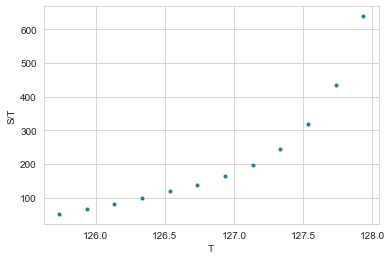

In [446]:
# Higgs not included in thermal or radiative corrections
temperatures = np.arange(TC-0.8, TC-3, -0.2)  #TC-10
action = []

r0 = 0.00001
dr = 0.002
rmax = 0.9
rmin = 0.2
tol = 1e-1

for t in temperatures:
    if t <= (TC-2.4):
        dr = 0.001
        tol = 1

    if t <= (TC-1.5) and t > (TC-2.4):
        dr = 0.002

    if t >= (TC-1):
        dr = 0.05

    #print(t-TC, dr)

    phiMin, = fsolve(dVdphi, phi[50], args = (t,))
    actionB = shootingActionAdjusted(r0, rmin, rmax, dr, phiMin, 0, undershoot = 1, tol = tol, actionTol = 1e4, temp = t)

    print("Action: ", actionB, "Temperature: ", t)
    action.append(actionB)

action = np.array(action)

plt.figure()
plt.plot(temperatures, action, '.')
plt.xlabel('T')
plt.ylabel('S/T')

Radius:  0.3464647474747475
Action:  803.911310221143 Temperature:  137.27397745891852
Radius:  0.29696979797979794
Action:  543.7454046748834 Temperature:  136.77397745891852
Radius:  0.2514344444444444
Action:  398.3400264380586 Temperature:  136.27397745891852
Radius:  0.22371727272727274
Action:  307.9005447873213 Temperature:  135.77397745891852
Radius:  0.2177778787878788
Action:  244.43074750775287 Temperature:  135.27397745891852
Radius:  0.18907080808080814
Action:  204.13749763011998 Temperature:  134.77397745891852
Radius:  0.17620212121212125
Action:  171.89700478908983 Temperature:  134.27397745891852
Radius:  0.16630313131313135
Action:  148.12396449531371 Temperature:  133.77397745891852
Radius:  0.15739404040404045
Action:  128.1881382599009 Temperature:  133.27397745891852
Radius:  0.1514546464646465
Action:  109.9842557552439 Temperature:  132.77397745891852


Text(0, 0.5, 'S/T')

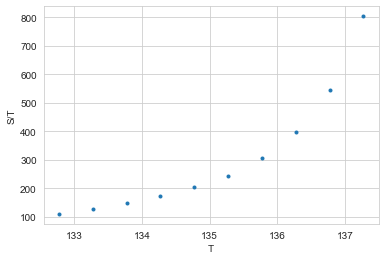

In [449]:
# Higgs included in thermal or radiative corrections
temperatures = np.arange(TC-2, TC-7, -0.5)  #TC-10
action = []

r0 = 0.00001
rmax = 0.5
tol = 2e-1

for t in temperatures:
    if t <= (TC-4.5):
        rmin = 0.13
        dr = 0.001

    if t <= (TC-3) and t > (TC-4.5):
        rmin = 0.22
        dr = 0.002

    if t >= (TC-2.5):
        rmin = 0.25
        dr = 0.05

    #print(t-TC, dr)

    phiMin, = fsolve(dVdphi, phi[70], args = (t,))
    actionB = shootingActionAdjusted(r0, rmin, rmax, dr, phiMin, 0, undershoot = 2, tol = tol, actionTol = 1e4, temp = t)

    print("Action: ", actionB, "Temperature: ", t)
    action.append(actionB)

action = np.array(action)

plt.figure()
plt.plot(temperatures, action, '.')
plt.xlabel('T')
plt.ylabel('S/T')

TC =  139.27
TN =  133.5765157250286
beta/H:  5377.542595713552
Latent heat:  0.02560808709080843


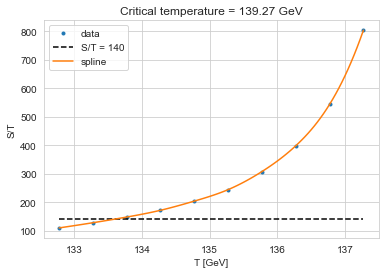

In [450]:
from scipy.interpolate import splev, splrep
from scipy.interpolate import InterpolatedUnivariateSpline

plt.figure()
plt.plot(temperatures, action, '.', label='data')
plt.xlabel('T [GeV]')
plt.ylabel('S/T')

nuc = np.linspace(140,140,100)
x = np.flip(temperatures)
y = np.flip(action)
spl = InterpolatedUnivariateSpline(x, y)
x2 = np.linspace(x[0], x[-1], 100)
y2 = spl(x2)
plt.plot(x2, nuc, 'k--', label='S/T = 140')
plt.plot(x2, y2, label='spline')
print('TC = ', np.around(TC, 2))
plt.title('Critical temperature = 139.27 GeV')
plt.legend()

def difference(x):
    return np.abs(spl(x) - 140)

TN, = fsolve(difference, 126)
print('TN = ', TN)

derivative = spl.derivative()
betaH = TN*derivative(TN)
print('beta/H: ', betaH)

alpha = latentHeat(TN, T0, v0)
print('Latent heat: ', alpha)